In [1]:
pip install -e ./cvaei


Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///Users/mayanknautiyal/Desktop/Codes/CVAEI/cvaei
ERROR: file:///Users/mayanknautiyal/Desktop/Codes/CVAEI/cvaei does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import cvaei
import torch
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device("mps")
from cvaei.models.cvae_inference import CVAE
from cvaei.helper import DataNormalizer
from cvaei.visualize import scatter_plot_ma2, scatter_plot


In [3]:

# input_dim = 10  
# latent_dim = 2
# conditional_dim = 5  
# encoder_hidden_dims = [256, 128, 64]
# decoder_hidden_dims = [64, 128, 256]


# network = CVAE(input_dim=input_dim, latent_dim=latent_dim, output_dim=input_dim,
#         conditional_dim=conditional_dim, encoder_hidden_dims=encoder_hidden_dims,
#         decoder_hidden_dims=decoder_hidden_dims)


# optimizer = optim.Adam(network.parameters(), lr=1e-3)


# num_samples = 1000  
# x_dummy = torch.randn(num_samples, input_dim)  
# theta = torch.tensor(x_dummy, dtype=torch.float32)

# c_dummy = torch.randn(num_samples, conditional_dim)
# data = torch.tensor(c_dummy, dtype=torch.float32)

# theta_normalizer = DataNormalizer()
# data_normalizer = DataNormalizer()

# # Fit and transform thetas
# theta_normalizer.fit(theta)
# train_theta_norm = theta_normalizer.transform(theta)

# # Fit and transform data
# data_normalizer.fit(data)
# train_data_norm = data_normalizer.transform(data)

# print(theta.shape, data.shape)

# train_dataset = TensorDataset(train_data_norm, train_theta_norm)
# train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)





# network.train_model(train_loader=train_loader, optimizer=optimizer, epochs=100, 
#                     device=device, theta_normalizer=theta_normalizer, data_normalizer=data_normalizer, forward_model=dummy)

In [4]:
def simulator(param, seed=42):
    """
    Simulate a given parameter combination using PyTorch tensors.

    Parameters
    ----------
    param : tensor
        Parameters to simulate (\theta).
    n : integer
        Time series length
    """
    torch.manual_seed(seed)
    
    n =  100
    m = len(param)
    g = torch.randn(n)
    gy = torch.randn(n) *  0.3
    y = torch.zeros(n)
    x = torch.zeros(n)
    for t in range(n):
        x[t] += g[t]
        for p in range(min(t, m)):
            x[t] += g[t -  1 - p] * param[p]
        y[t] = x[t] + gy[t]

    return y


def prior(num_samples):
    """
    Sample parameters or thetas from the prior using PyTorch tensors.

    Parameters
    ----------
    n : integer
        Number of random samples to draw or sample.
    """
    n = num_samples
    p = []
    trials =  0
    acc =  0
    while acc < n:
        trials +=  1
        r = torch.rand(2) * torch.tensor([4,  2]) + torch.tensor([-2, -1])
        if r[1] + r[0] >= -1 and r[1] - r[0] >= -1:
            p.append(r)
            acc +=  1
    return torch.stack(p)

def generate_data(num_samples=1000):
    theta = prior(num_samples=num_samples)
    data = torch.stack([simulator(t) for t in theta])
    return theta, data


In [5]:
theta, data = generate_data(1000)

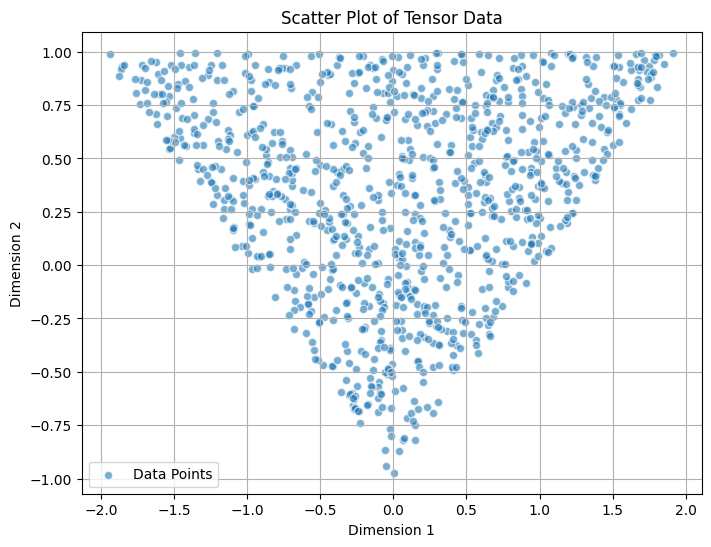

In [6]:
scatter_plot(theta)

In [7]:
input_dim = 2
latent_dim = 10
conditional_dim = 100
encoder_hidden_dims = [128, 128]
decoder_hidden_dims = [512,512,512]


network = CVAE(input_dim=input_dim, latent_dim=latent_dim, output_dim=input_dim,
        conditional_dim=conditional_dim, encoder_hidden_dims=encoder_hidden_dims,
        decoder_hidden_dims=decoder_hidden_dims)


optimizer = optim.AdamW(network.parameters(), lr=1e-3)


theta_normalizer = DataNormalizer()
data_normalizer = DataNormalizer()

# Fit and transform thetas
theta_normalizer.fit(theta)
train_theta_norm = theta_normalizer.transform(theta)

# Fit and transform data
data_normalizer.fit(data)
train_data_norm = data_normalizer.transform(data)

print(theta.shape, data.shape)

train_dataset = TensorDataset(train_data_norm, train_theta_norm)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

network.train_model(train_loader=train_loader, optimizer=optimizer, epochs=10, 
                    device=device, theta_normalizer=theta_normalizer,
                      data_normalizer=data_normalizer, forward_model= simulator)

torch.Size([1000, 2]) torch.Size([1000, 100])
Using CPU
Epoch [1/10], Beta: 0.0000, Average Loss: 5.9715, Recon Loss: 0.1404, Misfit Loss: 5.8311, KL Div: 0.1435
Epoch [2/10], Beta: 0.1000, Average Loss: 0.4124, Recon Loss: 0.0103, Misfit Loss: 0.3861, KL Div: 0.1603
Epoch [3/10], Beta: 0.2000, Average Loss: 0.1234, Recon Loss: 0.0030, Misfit Loss: 0.1104, KL Div: 0.0503
Epoch [4/10], Beta: 0.3000, Average Loss: 0.0361, Recon Loss: 0.0009, Misfit Loss: 0.0317, KL Div: 0.0116
Epoch [5/10], Beta: 0.4000, Average Loss: 0.0146, Recon Loss: 0.0003, Misfit Loss: 0.0128, KL Div: 0.0037
Epoch [6/10], Beta: 0.5000, Average Loss: 0.0076, Recon Loss: 0.0002, Misfit Loss: 0.0065, KL Div: 0.0019
Epoch [7/10], Beta: 0.6000, Average Loss: 0.0049, Recon Loss: 0.0001, Misfit Loss: 0.0041, KL Div: 0.0011
Epoch [8/10], Beta: 0.7000, Average Loss: 0.0034, Recon Loss: 0.0001, Misfit Loss: 0.0028, KL Div: 0.0007
Epoch [9/10], Beta: 0.8000, Average Loss: 0.0025, Recon Loss: 0.0001, Misfit Loss: 0.0021, KL Di

In [8]:

true_param = torch.tensor([0.6,0.2])
observed_data = simulator(true_param)
post = network.get_posterior(observed_data= observed_data, num_samples=10000)
post = theta_normalizer.inverse_transform(post)

torch.Size([10000, 10]) torch.Size([10000, 100])


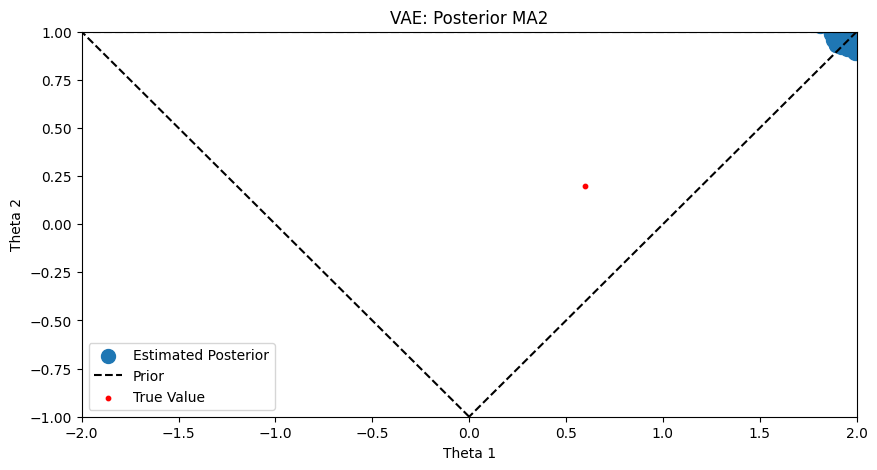

In [9]:
scatter_plot_ma2(post)

In [10]:
prior, simulator, posterior

NameError: name 'posterior' is not defined